Imports

In [2]:
import sys
!{sys.executable} -m pip install -q pandas numpy matplotlib seaborn scipy statsmodels scikit-learn lightgbm xgboost shap


[notice] A new release of pip is available: 25.0.1 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
#data
import os
import numpy as np
import pandas as pd

#viz
import matplotlib.pyplot as plt
import seaborn as sns

#stats
from scipy import stats
from scipy.stats import chi2_contingency
import statsmodels.api as sm

#ml
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#other
import warnings
warnings.filterwarnings('ignore')

Loading data

In [4]:
df = pd.read_csv("reddit_dead_internet_analysis_2026.csv")
print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (500, 11)


,comment_id,subreddit,account_age_days,user_karma,reply_delay_seconds,sentiment_score,avg_word_length,contains_links,is_bot_flag,bot_type_label,bot_probability
0,t1_3148938807,funny,2264,34192,1854,-0.60,4.62,False,False,None (Human),0.093
1,t1_2516748923,gaming,1654,2812,1033,0.15,5.84,False,False,None (Human),0.117
2,t1_833922318,politics,2442,37109,2703,0.35,5.73,False,False,None (Human),0.115
3,t1_3987809057,funny,168,32997,2811,-0.74,4.58,False,False,None (Human),0.094
4,t1_3931039688,gaming,801,25088,1721,-0.96,5.78,False,False,None (Human),0.116


In [5]:
df.describe()

,account_age_days,user_karma,reply_delay_seconds,sentiment_score,avg_word_length,bot_probability
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,1157.624000,25248.198000,1030.700000,0.014980,5.654300,0.156530
std,951.766304,14122.969163,1184.411096,0.581127,0.895203,0.074555
min,1.000000,308.000000,1.000000,-1.000000,4.030000,0.081000
25%,163.000000,13427.250000,7.000000,-0.472500,4.967500,0.101000
50%,1092.500000,24778.500000,459.000000,0.020000,5.695000,0.117000
75%,1960.000000,37111.500000,1925.000000,0.502500,6.250000,0.200000
max,2996.000000,49734.000000,3577.000000,1.000000,7.490000,0.465000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   comment_id           500 non-null    object 
 1   subreddit            500 non-null    object 
 2   account_age_days     500 non-null    int64  
 3   user_karma           500 non-null    int64  
 4   reply_delay_seconds  500 non-null    int64  
 5   sentiment_score      500 non-null    float64
 6   avg_word_length      500 non-null    float64
 7   contains_links       500 non-null    bool   
 8   is_bot_flag          500 non-null    bool   
 9   bot_type_label       500 non-null    object 
 10  bot_probability      500 non-null    float64
dtypes: bool(2), float64(3), int64(3), object(3)
memory usage: 36.3+ KB


Exploring Data

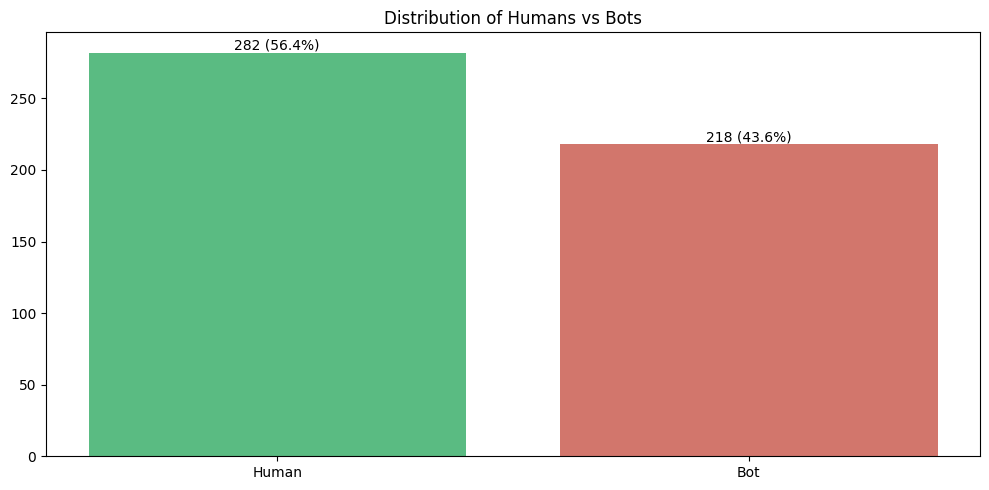

In [7]:
#distribution of human vs bots
#making graph
counts=df['is_bot_flag'].value_counts()
fig, ax = plt.subplots(figsize=(10,5))
color = ["#5abb82", "#d2766c"]
bars = ax.bar(['Human', 'Bot'],[counts[False], counts[True]], color=color)

#bar calc
total = counts[False]+counts[True]
percHuman=counts[False]/total
percBot=counts[True]/total
percents=[percHuman, percBot]

#bar label
for bar,p in zip(bars, percents):
    height = bar.get_height()
    ax.text(
        bar.get_x()+bar.get_width()/2,
        height,
        f'{int(height)} ({p:.1%})',
        ha='center',
        va='bottom'
    )
#other labels
ax.set_ylabel=('Count')
ax.set_title("Distribution of Humans vs Bots")
plt.tight_layout()
plt.show()



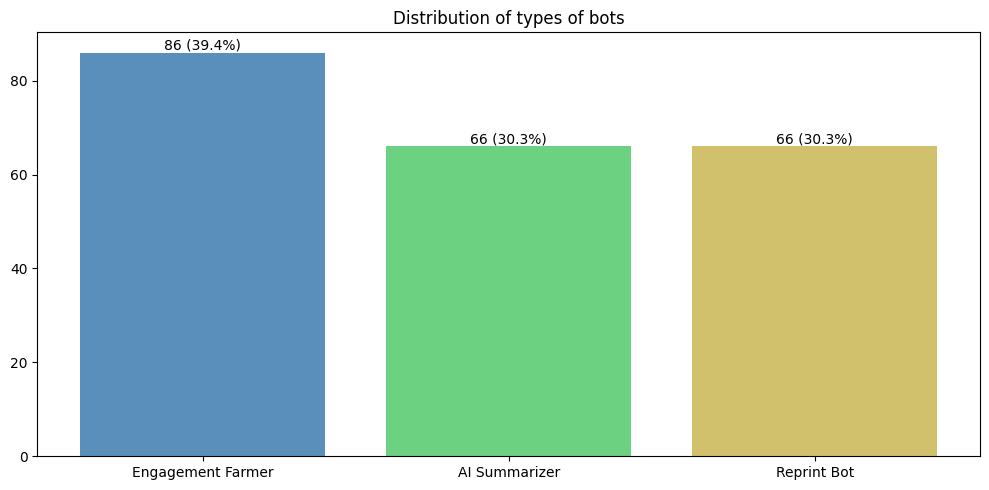

In [8]:
#distribution of types of bots
#making graph
bot_types = df['bot_type_label'].value_counts().iloc[1:4]
fig, ax = plt.subplots(figsize=(10,5))
color = ["#5a8fbb", "#6cd282", "#d2c16c"]
bars = ax.bar(bot_types.index,bot_types.values, color=color)

#bar calc
all_bots = df[df['is_bot_flag']==True]
total = all_bots.shape[0]
percents=bot_types.values/total

#bar label
for bar,p in zip(bars, percents):
    height = bar.get_height()
    ax.text(
        bar.get_x()+bar.get_width()/2,
        height,
        f'{int(height)} ({p:.1%})',
        ha='center',
        va='bottom'
    )

#other labels
ax.set_ylabel=('Count')
ax.set_title("Distribution of types of bots")
plt.tight_layout()
plt.show()

Boxplots for accounts flagged as bots & humans

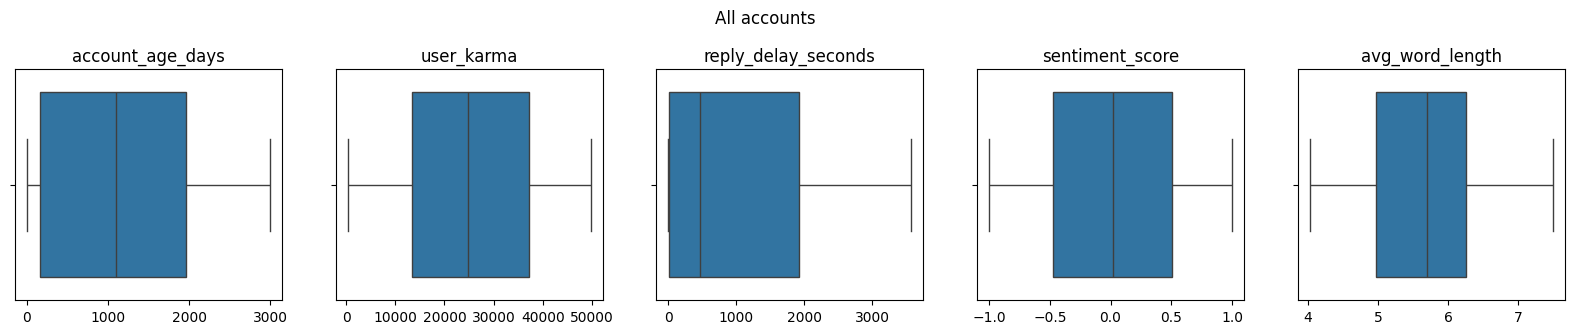

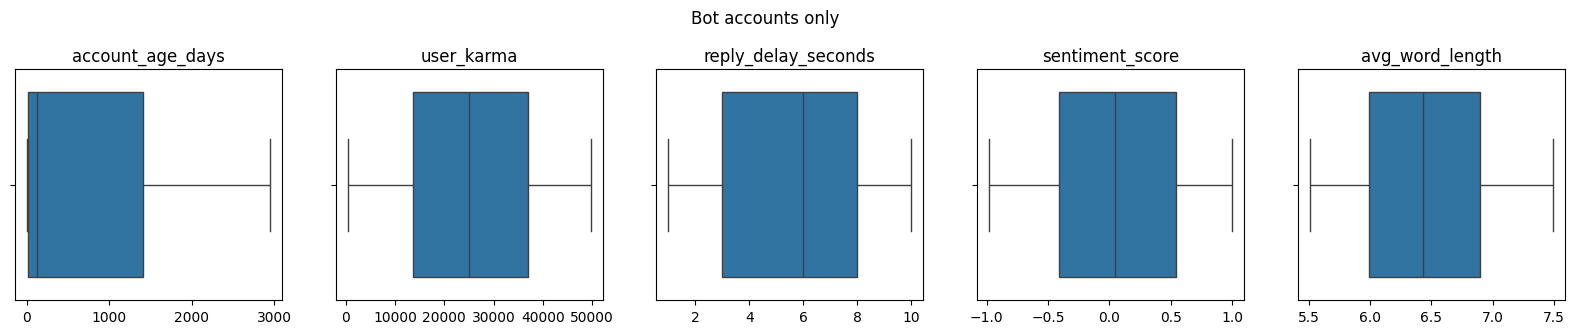

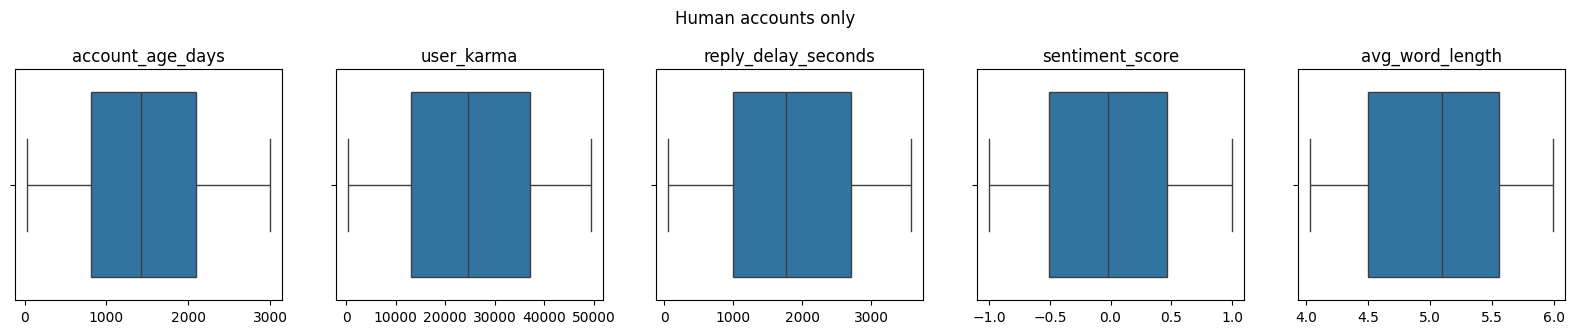

In [25]:
num_cols = ['account_age_days', 'user_karma', 'reply_delay_seconds', 'sentiment_score', 'avg_word_length']
fig, axes = plt.subplots(1,5, figsize=(20,3))
for ax, col in zip(axes, num_cols):
    sns.boxplot(x=df[col], ax=ax)
    ax.set_title(col)
    ax.set_xlabel("")
fig.suptitle("All accounts", y=1.08)
plt.show()

botdf=df[df['is_bot_flag']==True]
num_cols = ['account_age_days', 'user_karma', 'reply_delay_seconds', 'sentiment_score', 'avg_word_length']
fig, axes = plt.subplots(1,5, figsize=(20,3))
for ax, col in zip(axes, num_cols):
    sns.boxplot(x=botdf[col], ax=ax)
    ax.set_title(col)
    ax.set_xlabel("")
fig.suptitle("Bot accounts only", y=1.08)
plt.show()

humdf=df[df['is_bot_flag']==False]
num_cols = ['account_age_days', 'user_karma', 'reply_delay_seconds', 'sentiment_score', 'avg_word_length']
fig, axes = plt.subplots(1,5, figsize=(20,3))
for ax, col in zip(axes, num_cols):
    sns.boxplot(x=humdf[col], ax=ax)
    ax.set_title(col)
    ax.set_xlabel("")
fig.suptitle("Human accounts only", y=1.08)
plt.show()